# Amazon Title Reviews Sentiment - Bidirectional LSTM

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
import emoji, bz2
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("../input/processed/processed_data.csv")
df.head()

,rating,text,domain,clean_text
0,0.0,I liked the size and flat plug into the wall. ...,Electronics,like size flat plug wall usb port work
1,0.0,Bought for my son and within 6 moths it quit w...,Electronics,buy son within moth quit work buy something else
2,0.0,It seems like it will protect the AirPods dece...,Electronics,seem like protect airpods decent also feel cheap
3,0.0,The material is nice and the iPad fit pretty g...,Electronics,material nice ipad fit pretty good stand magne...
4,0.0,Penalty for trying to save a buck or two. Purc...,Electronics,penalty try save buck two purchase certified r...


In [5]:
df = df[["clean_text","rating"]]
df

,clean_text,rating
0,like size flat plug wall usb port work,0.0
1,buy son within moth quit work buy something else,0.0
2,seem like protect airpods decent also feel cheap,0.0
3,material nice ipad fit pretty good stand magne...,0.0
4,penalty try save buck two purchase certified r...,0.0
...,...,...
134995,use version another number year never disappoi...,2.0
134996,game engage could not put look great too br do...,2.0
134997,start great sound small package easy setup lov...,2.0
134998,app great fun help keep brain active decent gr...,2.0


In [6]:
# shape of data
print(f"Data consists of {df.shape[0]} rows and {df.shape[1]} columns.")

Data consists of 135000 rows and 2 columns.


In [7]:
# checking for null values
df.isna().sum()

clean_text    524
rating          0
dtype: int64

In [9]:
# dropping null values
df = df.dropna()

In [10]:
# checking for any duplicate in the data
df.duplicated().sum()

30879

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df1 = df
df1.shape

(103597, 2)

In [18]:
df1.rating.value_counts()

2.0    37857
0.0    35509
1.0    30231
Name: rating, dtype: int64

In [51]:
# For each rating, sample 30,000 rows
df = df1.groupby('rating', group_keys=False).apply(lambda x: x.sample(n=30000, random_state=42))

# Check the distribution to confirm
print(df['rating'].value_counts())

0.0    30000
1.0    30000
2.0    30000
Name: rating, dtype: int64


Text(0.5, 1.0, 'Countplot for Sentiment Labels')

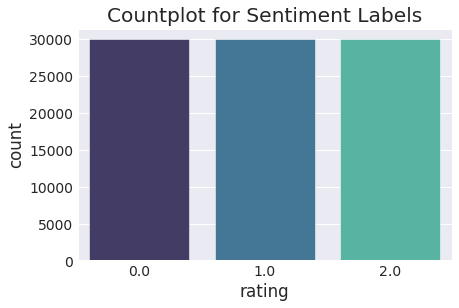

In [24]:
sns.countplot(df.rating,palette="mako")
plt.title("Countplot for Sentiment Labels")

* Classes are balanced. So, no need for oversampling or undersampling the target column.

In [53]:
df.dtypes

clean_text     object
rating        float64
dtype: object

In [56]:
df['rating'] = df['rating'].astype(int)
df['clean_text'] = df['clean_text'].astype(str)

# Cleaning Data

In [57]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(df,"clean_text")

,clean_text,rating
51776,product small rip easily,0
13699,able get w even w draw cable meet description ...,0
45030,glove warm ar might well wear glove sell look,0
8757,trash would hold purchase different one waste ...,0
10791,item charge work,0
...,...,...
134522,second time use norton security seem work quit...,2
31768,awesome beanie especially excited use come mon...,2
40178,great alex,2
125805,able watch show go,2


In [37]:
df.isna().sum()

clean_text    0
rating        0
dtype: int64

In [58]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text= re.sub(emoji.get_emoji_regexp(),"",text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

df["clean_text"] = df["clean_text"].apply(preprocess_text)

In [59]:
df.head(15)

,clean_text,rating
51776,product small rip easily,0
13699,able get w even w draw cable meet description ...,0
45030,glove warm ar might well wear glove sell look,0
8757,trash would hold purchase different one waste ...,0
10791,item charge work,0
56859,order year old small order many size,0
53805,come original order like suppose take long tim...,0
13686,cheap leather stand well take serveral attempt...,0
3353,work send back,0
91459,game fine enough regard visual simple far atta...,0


Text(0, 0.5, 'Text Length')

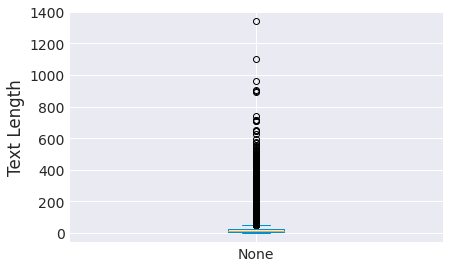

In [40]:
text_length = pd.Series([len(review.split()) for review in df1["clean_text"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

Text(0, 0.5, 'Frequency')

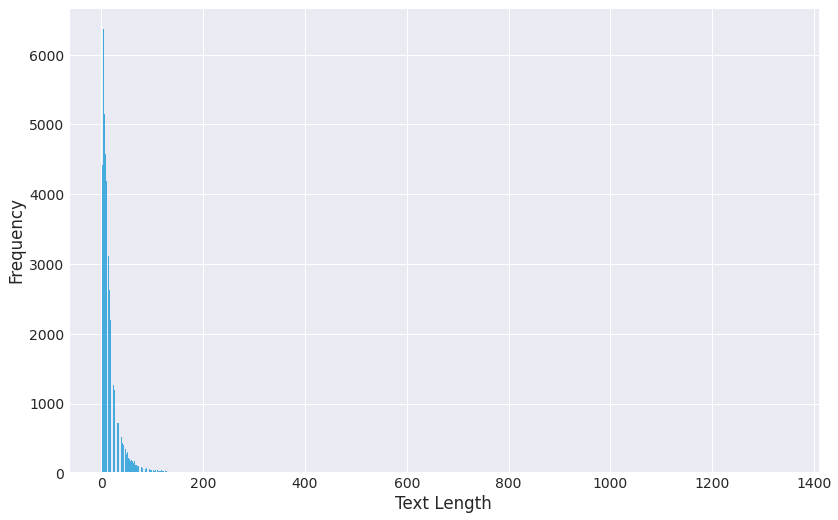

In [41]:
plt.figure(figsize=(12,8))
sns.histplot(text_length,palette="deep")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

### WordClouds
* Useful for viewing and analyzing words that are frequently used.

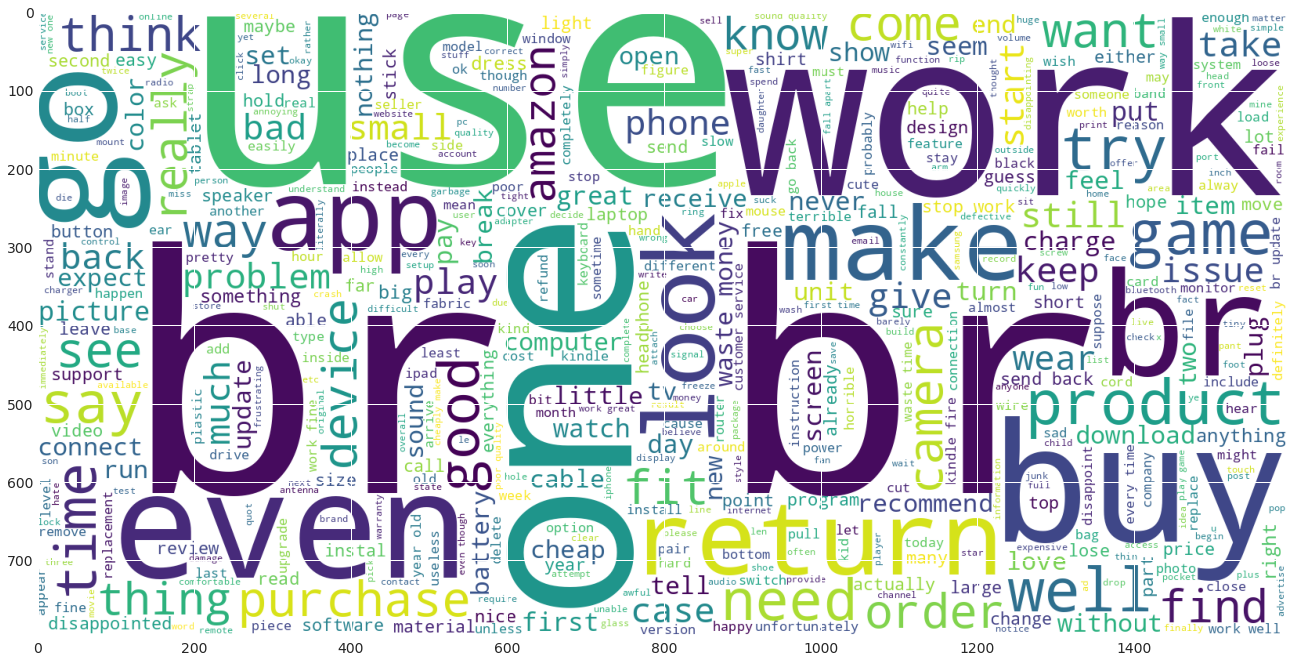

In [43]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df[df["rating"]==0].clean_text))
plt.imshow(wc1)

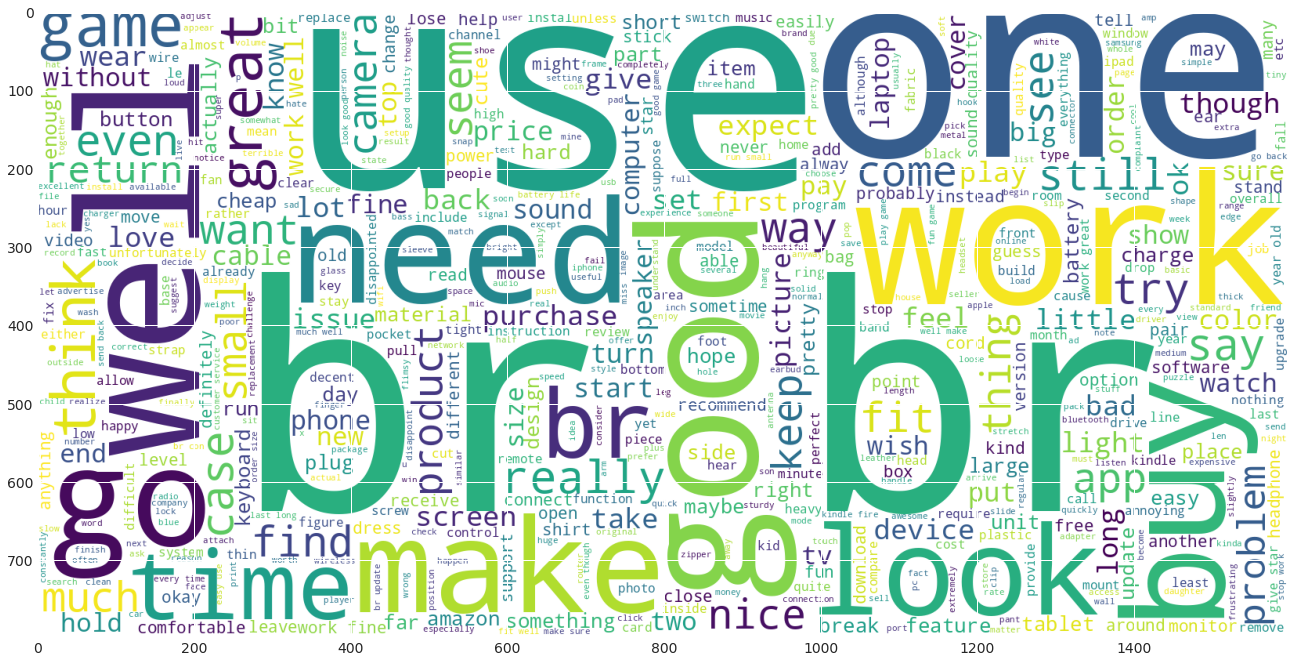

In [46]:
# Neutral Review WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df[df["rating"]==1].clean_text))
plt.imshow(wc)

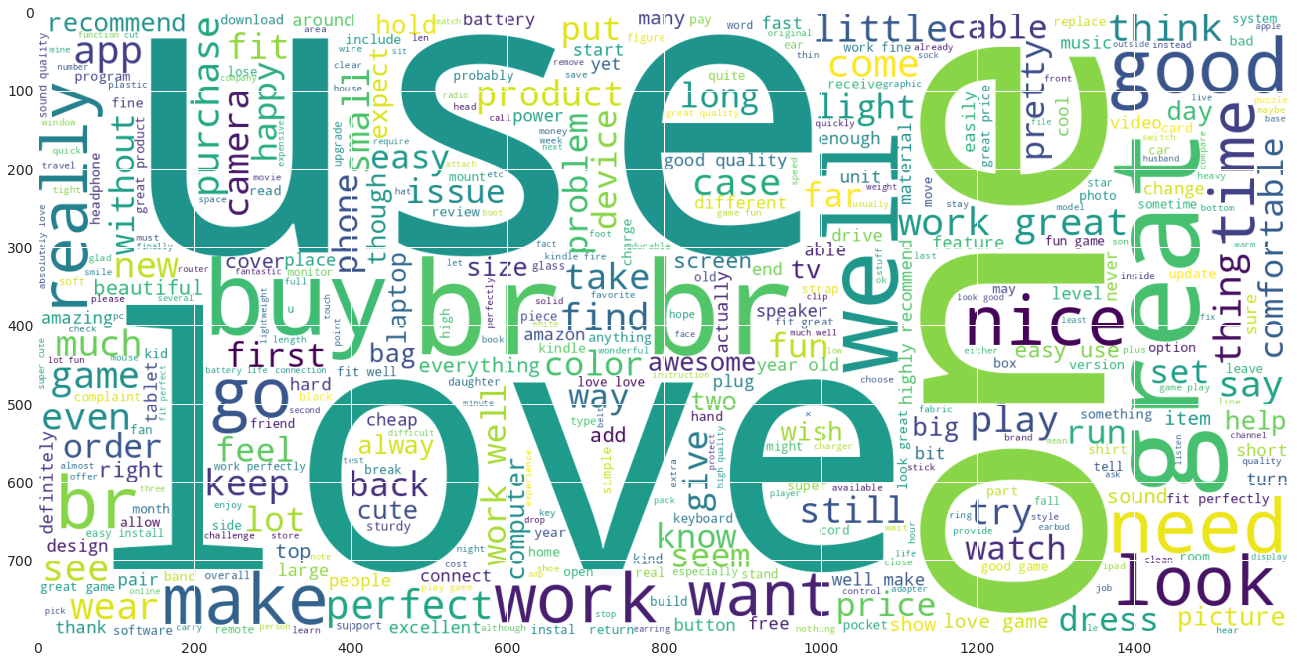

In [45]:
# Positive Review WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df[df["rating"]==2].clean_text))
plt.imshow(wc)

In [60]:
df.rating.unique()

array([0, 1, 2])

# Model Training

In [61]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["clean_text"]),np.array(df["rating"]), test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(67500,)
(22500,)


### Term Frequency- Inverse Document Frequency (TF-IDF)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_test_tf2 = tfidf2.transform(X_test)

#### Fitting Machine learning Models

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train_tf2, y_train)

RandomForestClassifier()

In [65]:
from sklearn.metrics import roc_auc_score
y_pred = rf.predict(X_test_tf2)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)
#roc = roc_auc_score(y_test,y_pred)
#print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred)}")
print(report)

              precision    recall  f1-score   support

           0       0.62      0.70      0.66      7448
           1       0.54      0.48      0.51      7577
           2       0.71      0.71      0.71      7475

    accuracy                           0.63     22500
   macro avg       0.63      0.63      0.63     22500
weighted avg       0.62      0.63      0.63     22500



In [66]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train_tf2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [67]:
y_pred2 = xgb.predict(X_test_tf2)
acc2 = accuracy_score(y_pred2, y_test)
report2 = classification_report(y_test, y_pred2)
#roc2 = roc_auc_score(y_test,y_pred2)
#print(f"Accuracy: {acc2*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred2)}")
print(report2)

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      7448
           1       0.56      0.48      0.52      7577
           2       0.72      0.69      0.71      7475

    accuracy                           0.63     22500
   macro avg       0.63      0.63      0.63     22500
weighted avg       0.63      0.63      0.63     22500



In [68]:
lgb = LGBMClassifier()
lgb.fit(X_train_tf2, y_train)

LGBMClassifier()

In [69]:
y_pred_lgb = lgb.predict(X_test_tf2)
acc_lgb = accuracy_score(y_pred_lgb, y_test)
report_lgb = classification_report(y_test, y_pred_lgb)
#roc_lgb = roc_auc_score(y_test,y_pred_lgb)
#print(f"Accuracy: {acc_lgb*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_lgb)}")
print(report_lgb)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66      7448
           1       0.57      0.51      0.54      7577
           2       0.72      0.72      0.72      7475

    accuracy                           0.64     22500
   macro avg       0.64      0.64      0.64     22500
weighted avg       0.64      0.64      0.64     22500



In [70]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tf2, y_train)

MultinomialNB()

In [71]:
y_pred3 = nb.predict(X_test_tf2)
acc3 = accuracy_score(y_pred3, y_test)
report3 = classification_report(y_test, y_pred3)
#roc3 = roc_auc_score(y_test,y_pred3)
#print(f"Accuracy: {acc3*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred3)}")
print(report3)

              precision    recall  f1-score   support

           0       0.65      0.64      0.64      7448
           1       0.53      0.57      0.55      7577
           2       0.73      0.68      0.70      7475

    accuracy                           0.63     22500
   macro avg       0.64      0.63      0.63     22500
weighted avg       0.64      0.63      0.63     22500



In [73]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tf2, y_train)

GradientBoostingClassifier()

In [74]:
y_pred4 = gb.predict(X_test_tf2)
acc4 = accuracy_score(y_pred4, y_test)
report4 = classification_report(y_test, y_pred4)
#roc4 = roc_auc_score(y_test,y_pred4)
#print(f"Accuracy: {acc4*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred4)}")
print(report4)

              precision    recall  f1-score   support

           0       0.56      0.72      0.63      7448
           1       0.54      0.45      0.49      7577
           2       0.70      0.62      0.66      7475

    accuracy                           0.60     22500
   macro avg       0.60      0.60      0.59     22500
weighted avg       0.60      0.60      0.59     22500



In [75]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf2, y_train)
y_pred5 = dt.predict(X_test_tf2)
acc5 = accuracy_score(y_pred5, y_test)
report5 = classification_report(y_test, y_pred5)
#roc5 = roc_auc_score(y_test,y_pred5)
#print(f"Accuracy: {acc5*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred5)}")
print(report5)

              precision    recall  f1-score   support

           0       0.54      0.56      0.55      7448
           1       0.45      0.42      0.43      7577
           2       0.60      0.61      0.60      7475

    accuracy                           0.53     22500
   macro avg       0.53      0.53      0.53     22500
weighted avg       0.53      0.53      0.53     22500



In [76]:
from sklearn.metrics import precision_score
ps = precision_score(y_test, y_pred)
ps_lgb = precision_score(y_test,y_pred_lgb)
ps2 = precision_score(y_test, y_pred2)
ps3 = precision_score(y_test, y_pred3)
ps4 = precision_score(y_test, y_pred4)
ps5 = precision_score(y_pred5,y_test)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
accuracys = [acc,acc2,acc3,acc4,acc5,acc_lgb]
#roc_scores = [roc, roc2, roc3, roc4,roc5, roc_lgb]
precision_scores = [ps,ps2,ps3,ps4,ps5,ps_lgb]
models = {"Random Forest":rf,"XGboost":xgb,"Naive Bayes":nb,"Gradient Boosting":gb,"Decision Tree":dt,"LGB Machine":lgb}

model_df = pd.DataFrame({"Models":models.keys(),"Accuracy":accuracys,"Precision Score":precision_scores,"Roc Scores": roc_scores}).sort_values("Roc Scores",ascending=False)

In [ ]:
# Summary of Machine Learning Models Performance
model_df

# Deep Learning
* Applying tokenizer for Bi-LSTM input after splitting data into training and testing/validation set.

In [77]:
from sklearn.model_selection import train_test_split
X = df["clean_text"]
y = df.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(X_train.shape)
display(X_test.shape)

(67500,)

(22500,)

In [85]:
display(y_train.shape)
display(y_test.shape)

(67500,)

(22500,)

In [87]:
y_train.unique()

array([0, 2, 1])

In [88]:
y_test.unique()

array([2, 0, 1])

In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [79]:
# using tokenizer to transform text messages into training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [80]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=64)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=64)

In [81]:
X_train_seq_padded[0]

array([ 925,  387,   10,  124,  937, 1596,  252, 5754,  435,  128,  428,
        498,   87,    1,    1,   82,   10,   69,  215,  417, 9813,  121,
         58,  191,   69,   22, 1363,  315,    4,  286,  997,  541,    5,
        286,  121,  463,  464,    5,   15,   91,   42,  456,  235, 1265,
        998,   20,   37,  165,   76,  687, 5031,    3,   76,   20, 8664,
          1,    1,  219,   87,  312,  104,   28,   47,  437], dtype=int32)

### Bidirectional LSTM
* Structure and Parameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1877760   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               132000    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,035,875
Trainable params: 2,035,875
Non-trainable params: 0
_________________________________________________________________


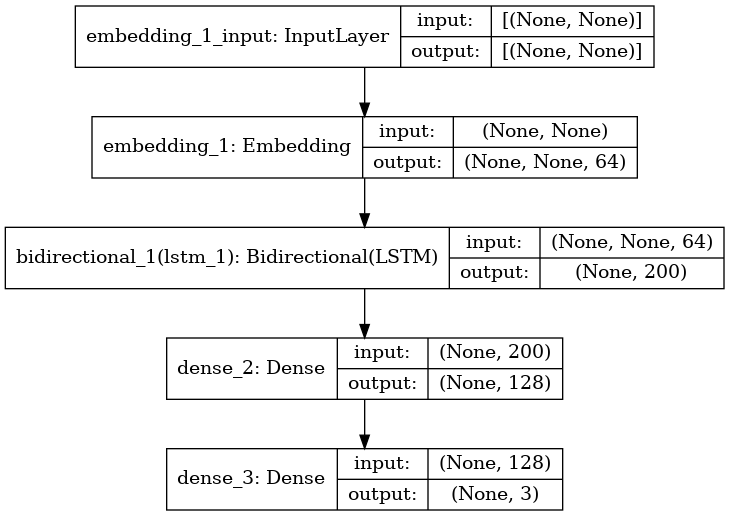

In [89]:
# construct model
BATCH_SIZE = 64

from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1,64))
model.add(Bidirectional(LSTM(100, dropout=0,recurrent_dropout=0)))
model.add(Dense(128, activation="relu"))
model.add(Dense(3,activation="softmax"))

model.compile("adam","sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
# Used for preventing ovefitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [91]:
history = model.fit(X_train_seq_padded, y_train,batch_size=BATCH_SIZE,epochs=10,
                    validation_data=(X_test_seq_padded, y_test),callbacks=[early_stop])

Epoch 1/10
1055/1055 [==============================] - 201s 187ms/step - loss: 0.8114 - accuracy: 0.6197 - val_loss: 0.7588 - val_accuracy: 0.6510
Epoch 2/10
1055/1055 [==============================] - 191s 181ms/step - loss: 0.6884 - accuracy: 0.6979 - val_loss: 0.7660 - val_accuracy: 0.6517
Epoch 3/10
1055/1055 [==============================] - 201s 190ms/step - loss: 0.6196 - accuracy: 0.7352 - val_loss: 0.8217 - val_accuracy: 0.6450
Epoch 4/10
1055/1055 [==============================] - 194s 184ms/step - loss: 0.5577 - accuracy: 0.7669 - val_loss: 0.8509 - val_accuracy: 0.6371
Epoch 5/10
1055/1055 [==============================] - 190s 180ms/step - loss: 0.4934 - accuracy: 0.7940 - val_loss: 0.9212 - val_accuracy: 0.6301
Epoch 6/10
1055/1055 [==============================] - 194s 184ms/step - loss: 0.4341 - accuracy: 0.8168 - val_loss: 1.0879 - val_accuracy: 0.6326
Epoch 00006: early stopping


In [95]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for each class
pred_train = model.predict(X_train_seq_padded)
pred_test = model.predict(X_test_seq_padded)

# Calculate and print ROC AUC scores for train and test sets
print('LSTM Recurrent Neural Network baseline (Train): ' + str(roc_auc_score(y_train, pred_train, multi_class='ovr')))
print('LSTM Recurrent Neural Network (Test): ' + str(roc_auc_score(y_test, pred_test, multi_class='ovr')))


LSTM Recurrent Neural Network baseline (Train): 0.9663052566980471
LSTM Recurrent Neural Network (Test): 0.7928662749109954


In [97]:
model.evaluate(X_test_seq_padded, y_test)

704/704 [==============================] - 25s 36ms/step - loss: 1.0879 - accuracy: 0.6326


[1.0879104137420654, 0.6325777769088745]

Text(0.5, 1.0, 'Training and Validation Accuracy')

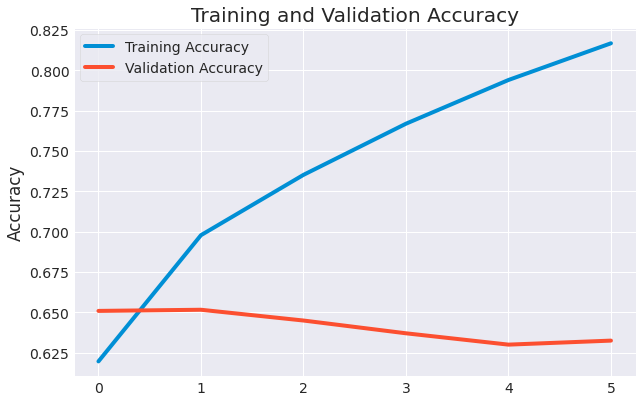

In [98]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

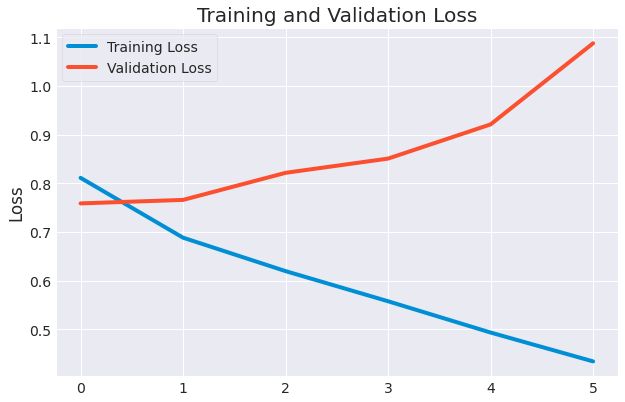

In [99]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

* Since roc_auc_score of LSTM is best among all the models we trained, so **Bidirectional LSTM is the best model** among all the other ones which we have trained.